## Image Classification On MNIST DataBase

In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

from torchvision.transforms import ToTensor

import time

### Imports training and testing data as dataframes

In [2]:
rawTrainingData = pd.read_csv("./data/data/train.csv")
rawTestingData = pd.read_csv("./data/data/test.csv")
print(rawTrainingData.shape)
print(rawTestingData.shape)

(42000, 785)
(28000, 784)


### Sets parameters

Specifies device although CPU is default, sets parameters for number of times the entire training set will be trained on, the number of samples processed at once, sets a random seed for reproducible results and sets learning rate for parameter adjustment

In [3]:
device = torch.device('cpu')
print(device)

epochs = 5
batchsize = 64
random.seed(111)
learningRate=0.001

cpu


### Separates dataframes into a pixel DF and a correct digit DF

In [4]:
pixelGrid = rawTrainingData.iloc[:, 1:].values.astype('float32')
correctDigits = rawTrainingData.iloc[:, 0].values.astype('int32')
trainDim=pixelGrid.shape[0]

testPixelGrid = rawTestingData.values.astype('float32')
testDim = testPixelGrid.shape[0]

print(pixelGrid.shape)
print(correctDigits.shape)
print(trainDim)
print()
print(testPixelGrid.shape)
print(testDim)

(42000, 784)
(42000,)
42000

(28000, 784)
28000


### Resizes our lists of 784 pixels into 28*28 pixel matrices

In [5]:
# Resizes dataframes into 28*28 matrices 
pixelGrid = pixelGrid.reshape(trainDim, 1, 28, 28)
testPixelGrid = testPixelGrid.reshape(testDim, 1, 28, 28)

print(pixelGrid.shape)
print(testPixelGrid.shape)

(42000, 1, 28, 28)
(28000, 1, 28, 28)


### Defines our Convolutional Nueral Network

In [6]:
# Based on parent NN class from PyTorch
# This class is not protected against overfitting
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Defines the device that model parameters live on

In [7]:
# Can move the parameters of the model to GPU but isn't doing anything here
# because I don't have a supported GPU
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Tests my datatypes, and tensor shapes with our CNN model

In [8]:
# Tests that our dataframe object can be converted to a tensor
# And instantiated in our CNN model
print(pixelGrid.shape)
x = torch.from_numpy(pixelGrid[0]).to(device)

print(x.shape)
# Adds a fourth dimension: (batch size, channels, height, width)
x = x.unsqueeze(0)
print(x.shape)

# Passes our 'x' tensor through the model which applies a series of convolutional and linear transformations
# Produces output tensor 'out'
out = model(x)
print(out)

(42000, 1, 28, 28)
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor([[-7.3031, -3.8769, -3.8392, -8.4986, -3.1129, -6.4905, -0.1012, -5.4189,
         -8.6026, -5.9752]], grad_fn=<LogSoftmaxBackward0>)


### Tests that we can display the predicted digit and visualize the pixel grid

Predicted digit: 6
torch.Size([28, 28])
(28, 28)


Text(0.5, 1.0, '6')

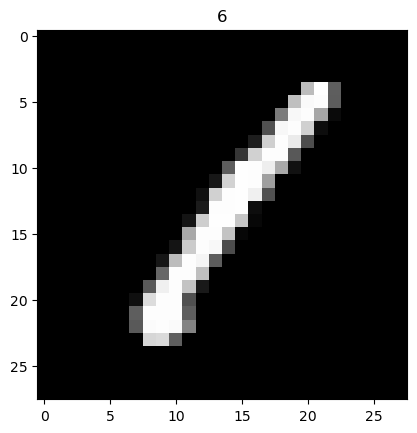

In [9]:
# obtain the predicted digit from output tensor
prediction = torch.argmax(out)
print("Predicted digit:", prediction.item())

# Removes the second dimension of 'x' tensor because imshow() expects a 2D array
x = x.squeeze(0, 1)
print(x.shape)

# Converts tensor to NumPy array
x_np = x.numpy()
print(x_np.shape)

# Plots NumPy array to show original digit
plt.imshow(x_np, cmap=plt.get_cmap("gray"))
plt.title(prediction.item())

### Turns NumPy arrays into a TensorDataset (A series of tensors)

In [10]:
trainDataset = TensorDataset(torch.from_numpy(pixelGrid), 
                             torch.from_numpy(correctDigits))

### Sets up dataloaders for training and testing that lets us load the data in batches for training

In [11]:
train_loader = torch.utils.data.DataLoader(
    trainDataset, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.from_numpy(testPixelGrid), batch_size=batchsize, shuffle=False)

### Sets up loss function and optimizer

The loss function is cross-entropy loss that penalizes the model for incorrect predictions and can show how accurate our model is, our goal is to minimize loss, the optimizer is a stochastic gradient descent with a learning rate of 0.001 which is used to update the model parameters during training

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), learningRate)

### Training loop for the CNN model

In [13]:
start_time = time.time()

# Specifies to train model, one epoch at a time
for epoch in range(epochs):
    
    # Sets model to training mode because some methods will work differently in testing/training
    model.train()

    # Loop through batches with inputs as data and correct digits as target
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Move data and target to device although not necesary here because we are using the CPU (default)
        data, target = data.to(device), target.to(device)

        # Zeroes out gradients because if not, the optimizer will accumulate gradients from all batches and the model will not learn correctly
        optimizer.zero_grad()

        # Call an instance of nn.module which calls the __call__ method which calls the forward method
        output = model(data)

        # Casts to LongTensor because it is the type that the loss function expects
        target = target.long()

        # Computes the cross-entropy loss
        loss = criterion(output, target)

        # Backpropagates the gradients of the loss with respect to model's parameters
        loss.backward()

        # updates the model's parameters based on the computed gradients
        optimizer.step()

        # print progress every 100 batches
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

Train Epoch: 0 [0/42000 (0%)]	Loss: 5.614733
Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.327243
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.081875
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.175137
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.140837
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.186608
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.151019
Train Epoch: 1 [0/42000 (0%)]	Loss: 0.100147
Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.020962
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.046888
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.031469
Train Epoch: 1 [25600/42000 (61%)]	Loss: 0.060125
Train Epoch: 1 [32000/42000 (76%)]	Loss: 0.115600
Train Epoch: 1 [38400/42000 (91%)]	Loss: 0.023939
Train Epoch: 2 [0/42000 (0%)]	Loss: 0.028654
Train Epoch: 2 [6400/42000 (15%)]	Loss: 0.012031
Train Epoch: 2 [12800/42000 (30%)]	Loss: 0.038307
Train Epoch: 2 [19200/42000 (46%)]	Loss: 0.069903
Train Epoch: 2 [25600/42000 (61%)]	Loss: 0.004050
Train Epoch: 2 [32000/42000 (76%)]	Loss: 0.010236
Train Epoch: 2 [38

### Calculate Training Accuracy

In [14]:
# Set the model to evaluation mode
model.eval().to(device)

# Ensures gradients are not computed
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)

        total += target.size(0)
        correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total

    print('Training accuracy: {:.2f}%'.format(accuracy))

Training accuracy: 99.62%


### Make predictions on the test data

In [15]:
predictions = np.array(()).astype(int)

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)

        _, pred = torch.max(output.data, axis=1)
        pred = pred.to(torch.device('cpu'))

        predictions = np.append(predictions, pred.numpy())
    """ predictions = model(test)
    predicted_labels = np.argmax(predictions, axis=1) """


print(predictions)

[2 0 9 ... 3 9 2]


### Output predictions into CSV file

In [16]:
# assume your predicted labels are stored in a numpy array called "predictions"
image_ids = list(range(1, len(predictions)+1))
df = pd.DataFrame({"ImageId": image_ids, "Label": predictions})
df.set_index("ImageId", inplace=True)

# export the DataFrame to a CSV file
df.to_csv("submission.csv", index=True)

### Display First 25 Test Results using trained CNN

(28000, 1, 28, 28)
torch.Size([25, 1, 28, 28])


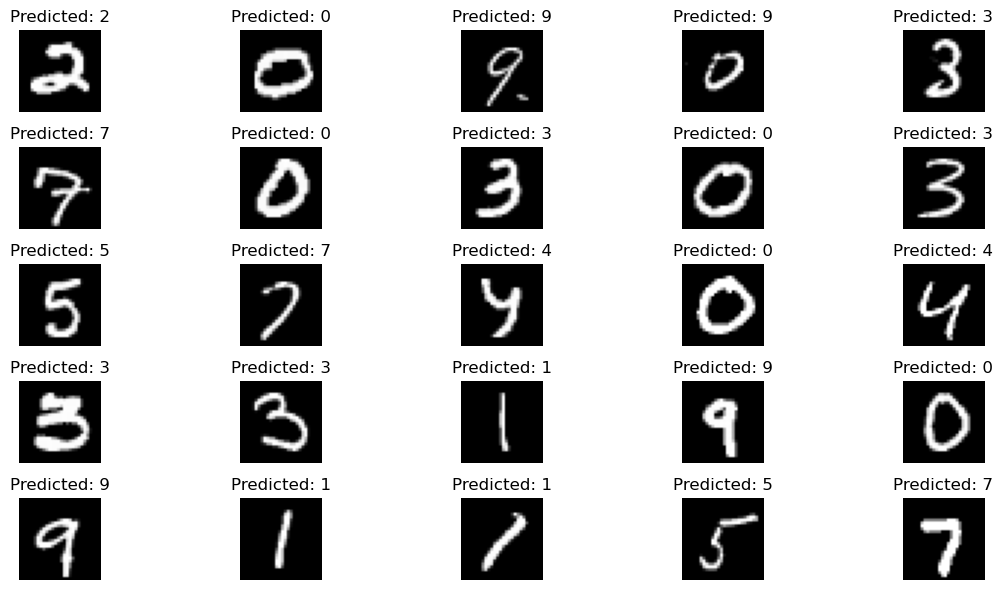

In [17]:
model.eval().to(torch.device('cpu'))

print(testPixelGrid.shape)
temp2 = torch.from_numpy(testPixelGrid[:25])
temp2 = temp2.reshape(temp2.shape[0], 1, 28, 28)
print(temp2.shape)

# Get predictions for the first 25 images
with torch.no_grad():
    predictions = model(temp2)
    predicted_labels = np.argmax(predictions, axis=1)

# Display images with predicted labels
fig, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(temp2[i].reshape(28, 28), cmap='gray')
    ax[row, col].set_title(
        f"Predicted: {predicted_labels[i]}")
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()